In [62]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
%matplotlib inline
import datetime
import csv
import math
import time
from ProgressBar import ProgressBar

import nltk
import string
from collections import defaultdict
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfVectorizer

from sklearn.decomposition import LatentDirichletAllocation
from sklearn.linear_model import Lasso

In [22]:
all_data_list = []
for year in range(1997,2007):
    data = pd.read_csv('{}_Output.csv'.format(year), header=None)
    all_data_list.append(data) # list of dataframes
data = pd.concat(all_data_list, axis=0)
data.columns = ['id','date','headline', 'lead']

In [23]:
data['yearmonth'] = map(lambda x: x[:7], data.date)

In [24]:
def getStems(lead):
    stemmer = nltk.stem.SnowballStemmer("english")
    tokens = nltk.word_tokenize(''.join(ch for ch in lead if ch not in set(string.punctuation)))
    return map(lambda x: stemmer.stem(x.decode('utf-8')), tokens)

In [25]:
def joinstems(stemlist):
    return ' '.join(stem for stem in stemlist)

In [26]:
stems = map(getStems, data.lead)

In [27]:
data['leadstems'] = map(joinstems, stems)

In [28]:
countVec = CountVectorizer(stop_words='english', max_df=0.8, min_df=.005, strip_accents='unicode')
wordMatrix = countVec.fit_transform(data.leadstems)

In [29]:
unigramVocab = countVec.get_feature_names()

In [30]:
lda = LatentDirichletAllocation(n_topics=10)

In [41]:
ldaDocs = lda.fit_transform(wordMatrix)

In [49]:
ldaDocs[:5]

array([[ 9311.26920099,  7930.08686652,  1550.73609563,  4712.01505464,
         6186.66128937,  2646.42174912,  8083.54457943,  3914.98264499,
         5403.65219996,  5188.63031933],
       [ 7685.23340941,  6888.50405784,  1556.63843699,  5360.47934504,
         4747.30652328,  2738.15384425,  7839.16203017,  3457.70953608,
         4752.99846099,  4678.81435594],
       [ 7972.61082997,  6432.14596008,  1445.52245549,  5013.77046658,
         4251.39260053,  2521.83235214,  7945.97525243,  4384.34869188,
         4386.02249602,  5028.37889487],
       [ 9737.29313872,  6999.31005759,  1724.58886741,  4935.60944363,
         6410.1928017 ,  2994.64566509,  8993.80980056,  3841.88215867,
         4620.32864211,  5572.33942451],
       [ 9342.14453334,  6414.5080085 ,  1731.09020409,  4943.35436657,
         4504.07705077,  2789.01227145,  8585.02330807,  4237.72681206,
         4036.59581365,  4801.46763149]])

In [33]:
lda.components_.shape

(10, 1404)

In [34]:
num_top_words = 10
topic_words = []

for topic in lda.components_:
    word_idx = np.argsort(topic)[::-1][0:num_top_words]
    topic_words.append([unigramVocab[i] for i in word_idx])

In [39]:
topicDF = pd.DataFrame(topic_words)
topicDF.index = ['Topic {}'.format(i) for i in range(1,11)]
topicDF.columns = ['Stem {}'.format(i) for i in range(1,11)]
topicDF

,Stem 1,Stem 2,Stem 3,Stem 4,Stem 5,Stem 6,Stem 7,Stem 8,Stem 9,Stem 10
Topic 1,bank,billion,compani,said,exchang,invest,secur,firm,bid,offer
Topic 2,feder,year,court,compani,like,time,say,busi,peopl,use
Topic 3,said,unit,compani,cut,state,oil,airlin,euro,investig,european
Topic 4,new,york,group,account,agenc,advertis,media,unit,million,offic
Topic 5,fund,bond,ago,rate,10yr,tbill,digit,sourc,year,buyer
Topic 6,million,percent,said,year,share,quarter,profit,sale,compani,cent
Topic 7,internet,comput,network,onlin,compani,televis,bankruptci,softwar,british,offer
Topic 8,percent,market,price,stock,rate,drug,week,month,year,economi
Topic 9,execut,mr,chief,compani,said,presid,chairman,offic,manag,year
Topic 10,million,compani,said,share,base,yesterday,buy,agre,percent,stock


## Group by month

In [40]:
grouped = data.groupby('yearmonth')

In [89]:
topicsByMonth = np.zeros((len(grouped.groups.keys()),ldaDocs.shape[1]))
for i, month in enumerate(np.sort(grouped.groups.keys())):
    topicsByMonth[i] = np.mean(ldaDocs[grouped.get_group(month).index], axis=0)

In [90]:
topicsByMonth.shape

(120, 10)

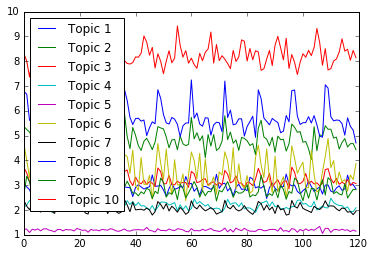

In [91]:
for topic in range(topicsByMonth.shape[1]):
    plt.plot(topicsByMonth[:,topic], label='Topic {}'.format(topic+1))
plt.legend(loc='best')

In [92]:
topicsByMonth

array([[ 2.99975417,  5.36728806,  3.71410122, ...,  6.78337224,
         2.63345958,  8.30456716],
       [ 2.9327754 ,  5.2450864 ,  3.49061144, ...,  6.66747328,
         3.36327245,  7.99958561],
       [ 2.81876934,  5.14562217,  3.15006391, ...,  5.61160324,
         3.13291441,  7.36478763],
       ..., 
       [ 3.0121292 ,  4.67361621,  2.98751598, ...,  5.37396196,
         2.66208786,  8.03832937],
       [ 3.02557302,  4.67934198,  3.11341553, ...,  5.21753301,
         2.83139309,  8.43440842],
       [ 2.84948611,  4.43209019,  3.06755375, ...,  4.70358733,
         2.8186472 ,  8.14258842]])

## CCI

In [56]:
CCI = pd.read_csv('CCI.csv')[['TIME','Value']]
CCI.set_index('TIME', inplace=True)
CCI.head()

,Value
TIME,
1960-01,101.5840
1960-02,101.3255
1960-03,101.1023
1960-04,100.9791
1960-05,101.0102


In [57]:
CCIlimited = CCI.iloc[np.where(CCI.index=='1997-01')[0][0]:(np.where(CCI.index=='2006-12')[0]+1)[0]]

In [58]:
CCIlimited.shape

(120, 1)

## Assembling predictors

In [93]:
X = topicsByMonth

In [94]:
X.shape

(120, 10)

In [95]:
y = CCIlimited.Value.values

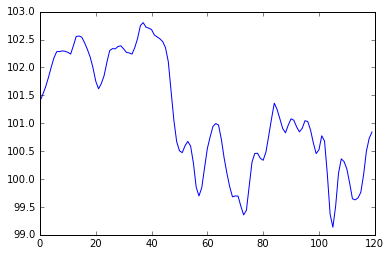

In [96]:
plt.plot(y)

In [97]:
lasso = Lasso(alpha=10)

In [98]:
lasso.fit(X[:-10,:],y[:-10])
pred = lasso.predict(X[-10:,:])
lasso.score(X[-10:,:],y[-10:])

-6.8486976598013873

In [99]:
X[-10:,:].shape

(10, 10)

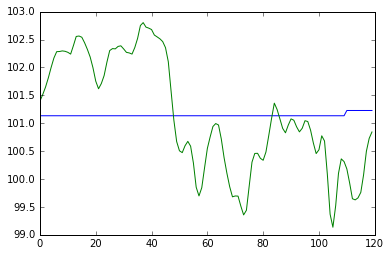

In [100]:
plt.plot(np.concatenate((np.mean(y)*np.ones(110),pred)))
plt.plot(y)